# Sentiment Analysis

In [2]:
# import all libraries for Sentiment Analysis for Indonesian Language
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory


## Load Dataset

In [3]:
# load tsv dataset
df = pd.read_csv('merged_train_valid_file.tsv', sep='\t')

In [4]:
df

,text,label
0,tidak enak,negative
1,restoran ini menawarkan makanan sunda . kami m...,positive
2,lokasi di alun alun masakan padang ini cukup t...,positive
3,betapa bejad kader gerindra yang anggota dprd ...,negative
4,kampiun bistro berada di jalan . kebon kawung ...,positive
...,...,...
12253,tidak kecewa,positive
12254,enak rasa masakan nya apalagi kepiting yang me...,positive
12255,hormati partai-partai yang telah berkoalisi,neutral
12256,"pagi pagi di tol pasteur sudah macet parah , b...",negative


## Preprocessing

### 1. Encode Labels

In [5]:
# print unique label
print(df['label'].unique())

['negative' 'positive' 'neutral']


In [6]:
# label encoding using LabelEncoder
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_processed = df.copy()
df_processed['label encode'] = le.fit_transform(df_processed['label'])


In [7]:
df_processed

,text,label,label encode
0,tidak enak,negative,0
1,restoran ini menawarkan makanan sunda . kami m...,positive,2
2,lokasi di alun alun masakan padang ini cukup t...,positive,2
3,betapa bejad kader gerindra yang anggota dprd ...,negative,0
4,kampiun bistro berada di jalan . kebon kawung ...,positive,2
...,...,...,...
12253,tidak kecewa,positive,2
12254,enak rasa masakan nya apalagi kepiting yang me...,positive,2
12255,hormati partai-partai yang telah berkoalisi,neutral,1
12256,"pagi pagi di tol pasteur sudah macet parah , b...",negative,0


### 2. Stemming

In [ ]:
# # stemmer
# factory = StemmerFactory()
# stemmer = factory.create_stemmer()

# df_processed['text'] = df_processed['text'].apply(lambda x: stemmer.stem(x))
# df_processed 

In [3]:
# df_processed = pd.read_csv('train_valid_stemmed.csv')

In [4]:
# df_processed

,text,label,label encode
0,tidak enak,negative,0
1,restoran ini tawar makan sunda kami mes ayam g...,positive,2
2,lokasi di alun alun masakan padang ini cukup k...,positive,2
3,betapa bejad kader gerindra yang anggota dprd ...,negative,0
4,kampiun bistro ada di jalan kebon kawung belah...,positive,2
...,...,...,...
12253,tidak kecewa,positive,2
12254,enak rasa masakan nya apalagi kepiting yang se...,positive,2
12255,hormat partai yang telah koalisi,neutral,1
12256,pagi pagi di tol pasteur sudah macet parah bik...,negative,0


In [27]:
# save to csv
#df_processed.to_csv('train_valid_stemmed.csv', index=False)

### 3. Stopwords Removal

In [8]:
# stopword removal indonesia language
stopword = StopWordRemoverFactory().create_stop_word_remover()
df_processed['text'] = df_processed['text'].apply(lambda x: stopword.remove(x))

df_processed

,text,label,label encode
0,enak,negative,0
1,restoran menawarkan makanan sunda . memesan ay...,positive,2
2,lokasi alun alun masakan padang cukup terkenal...,positive,2
3,betapa bejad kader gerindra anggota dprd menca...,negative,0
4,"kampiun bistro berada jalan . kebon kawung , s...",positive,2
...,...,...,...
12253,kecewa,positive,2
12254,enak rasa masakan nya kepiting menyenangkan me...,positive,2
12255,hormati partai-partai telah berkoalisi,neutral,1
12256,"pagi pagi tol pasteur macet parah , bikin jeng...",negative,0


### 4. Tokenization

In [9]:
# tokenize the data
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=10000, oov_token='x')
tokenizer.fit_on_texts(df_processed['text'].values)
word_index = tokenizer.word_index


In [10]:
len(word_index)

18216

In [11]:
# convert text to sequence
sequences = tokenizer.texts_to_sequences(df_processed['text'].values)
padded = pad_sequences(sequences, maxlen=100, padding='post', truncating='post')


In [12]:
padded

array([[   3,    0,    0, ...,    0,    0,    0],
       [  16,  550,    4, ...,    0,    0,    0],
       [  53, 3662, 3662, ...,    0,    0,    0],
       ...,
       [6741,  288,  288, ...,    0,    0,    0],
       [ 297,  297,  939, ...,    0,    0,    0],
       [ 439,  204,  565, ...,    0,    0,    0]])

## Model    

In [46]:
# function to create model
def create_model(input_length, vocab_size, lstm_units, dropout_rate, dense_units):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, 64, input_length=input_length),
        tf.keras.layers.LSTM(lstm_units, return_sequences=True),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.LSTM(int(lstm_units/2)),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(dense_units, activation='relu'),
        tf.keras.layers.Dense(3, activation='softmax')
    ])

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [74]:
# # create model 
# model = tf.keras.wrappers.scikit_learn.KerasClassifier(build_fn=create_model, epochs=100, verbose=1)

C:\Users\fahre\AppData\Local\Temp\ipykernel_5096\4025555447.py:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = tf.keras.wrappers.scikit_learn.KerasClassifier(build_fn=create_model, epochs=100, verbose=1)


In [72]:
# # hyperparameter tuning
# from sklearn.model_selection import GridSearchCV

param_grid = {
    'input_length': [padded.shape[1]],
    'vocab_size': [len(word_index)+1],
    'lstm_units': [128, 256],
    'dropout_rate': [0.1, 0.2],
    'dense_units': [64, 128],
    'epochs': [100]
}

# grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, verbose=1)


### Scenario 1: Train-Valid 80-20,  

In [48]:
# from sklearn.model_selection import train_test_split
# # prepare train and validation data
# X_train, X_test, y_train, y_test = train_test_split(padded, df_processed['label encode'].values, test_size=0.2, random_state=42)

# # one hot encoding
# y_train = tf.keras.utils.to_categorical(y_train)
# y_test = tf.keras.utils.to_categorical(y_test)


In [65]:


# train in grid search
# grid_result = grid.fit(X_train, y_train)


307/307 [==============================] - 36s 107ms/step - loss: 0.9221 - accuracy: 0.5857


In [66]:
# # Print best hyperparameters and accuracy
# print("Best Hyperparameters: ", grid_result.best_params_)
# print("Best Accuracy: ", grid_result.best_score_)

Best Hyperparameters:  {'dense_units': 64, 'dropout_rate': 0.1, 'input_length': 100, 'lstm_units': 128, 'vocab_size': 13916}
Best Accuracy:  0.5868860284487406


In [69]:
# # Evaluate the best model
# best_model_8020 = grid_result.best_estimator_

# # Predict labels for the test data using the best model
# y_pred_best_8020 = best_model_8020.predict(X_test)

# # Calculate accuracy
# accuracy_best_8020 = np.mean(y_pred_best_8020 == y_test)

# # Print the accuracy
# print('Accuracy of the best model: {:.2%}'.format(accuracy_best_8020))

77/77 [==============================] - 4s 34ms/step
Accuracy of the best model: 56.89%


In [50]:
# from keras.callbacks import EarlyStopping

# # Define the EarlyStopping callback
# early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, verbose=1)

# model_without_regularization = create_model(padded.shape[1], len(word_index)+1, 128, 0.3, 64)
# model_without_regularization_history = model_without_regularization.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)

Epoch 1/100
307/307 [==============================] - 37s 109ms/step - loss: 0.9232 - accuracy: 0.5863 - val_loss: 0.9225 - val_accuracy: 0.5689
Epoch 2/100
307/307 [==============================] - 35s 113ms/step - loss: 0.9178 - accuracy: 0.5869 - val_loss: 0.9219 - val_accuracy: 0.5689
Epoch 3/100
307/307 [==============================] - 32s 103ms/step - loss: 0.9145 - accuracy: 0.5869 - val_loss: 0.9210 - val_accuracy: 0.5689
Epoch 4/100
307/307 [==============================] - 30s 99ms/step - loss: 0.9149 - accuracy: 0.5869 - val_loss: 0.9203 - val_accuracy: 0.5689
Epoch 4: early stopping


In [55]:
# from sklearn.metrics import classification_report

# model_without_regularization_classreport = classification_report(y_test.argmax(axis=1), model_without_regularization.predict(X_test).argmax(axis=1), target_names=['negative', 'neutral', 'positive'], zero_division=1)
# print(model_without_regularization_classreport)

77/77 [==============================] - 2s 29ms/step
              precision    recall  f1-score   support

    negative       1.00      0.00      0.00       806
     neutral       1.00      0.00      0.00       251
    positive       0.57      1.00      0.73      1395

    accuracy                           0.57      2452
   macro avg       0.86      0.33      0.24      2452
weighted avg       0.75      0.57      0.41      2452



### Scenario 2: Train-Valid 90-10,

In [70]:
# X_train90, X_test10, y_train90, y_test10 = train_test_split(padded, df_processed['label encode'].values, test_size=0.1, random_state=42)

# # train model with best hyperparameters
# grid_result_9010 = grid.fit(X_train90, y_train90)

345/345 [==============================] - 36s 97ms/step - loss: 0.9201 - accuracy: 0.5836


In [71]:
# # Evaluate the best model
# best_model_9010 = grid_result_9010.best_estimator_

# # Predict labels for the test data using the best model
# y_pred_best_9010 = best_model_9010.predict(X_test10)

# # Calculate accuracy
# accuracy_best_9010 = np.mean(y_pred_best_9010 == y_test10)

# # Print the accuracy
# print('Accuracy of the best model: {:.2%}'.format(accuracy_best_9010))

39/39 [==============================] - 2s 32ms/step
Accuracy of the best model: 57.34%


### Scenario 3: Train-Valid 80-20, epoch=100

In [25]:
# from sklearn.model_selection import train_test_split

# # prepare train and validation data
# X_train_e100_8020, X_test_e100_8020 , y_train_e100_8020 , y_test_e100_8020 = train_test_split(padded, df_processed['label encode'].values, test_size=0.2, random_state=42)




In [ ]:
# train in grid search
# grid_result = grid.fit(X_train_e100_8020, y_train_e100_8020)

### Scenario 4 : Train-Valid 80-20, using different architecture (FIX)

In [13]:
from sklearn.model_selection import train_test_split

# prepare train and validation data
X_train_e100_8020, X_test_e100_8020 , y_train_e100_8020 , y_test_e100_8020 = train_test_split(padded, df_processed['label encode'].values, test_size=0.2, random_state=42)


In [14]:
# 
vocab_size = len(word_index)+1
input_length = padded.shape[1]
lstm_units = 128
dropout_rate = 0.3
dense_units = 32

from keras.callbacks import EarlyStopping

# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, verbose=1)

model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, 32, input_length=input_length),
        tf.keras.layers.SpatialDropout1D(0.2),
        tf.keras.layers.LSTM(lstm_units, return_sequences=True),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.LSTM(int(lstm_units/2), return_sequences=True),
        tf.keras.layers.Conv1D(64, 5, activation='relu'),
        tf.keras.layers.GlobalMaxPooling1D(),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(dense_units, activation='relu'),
        tf.keras.layers.Dense(3, activation='softmax')
    ])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    

In [15]:
y_train_e100_8020 = tf.keras.utils.to_categorical(y_train_e100_8020)
y_test_e100_8020 = tf.keras.utils.to_categorical(y_test_e100_8020)

In [16]:
model.fit(X_train_e100_8020, y_train_e100_8020, epochs=100, validation_data=(X_test_e100_8020, y_test_e100_8020),callbacks=[early_stopping], verbose=1)

Epoch 1/100
307/307 [==============================] - 43s 119ms/step - loss: 0.6789 - accuracy: 0.7104 - val_loss: 0.5192 - val_accuracy: 0.7814
Epoch 2/100
307/307 [==============================] - 37s 119ms/step - loss: 0.3750 - accuracy: 0.8599 - val_loss: 0.3765 - val_accuracy: 0.8569
Epoch 3/100
307/307 [==============================] - 37s 121ms/step - loss: 0.2304 - accuracy: 0.9197 - val_loss: 0.3926 - val_accuracy: 0.8564
Epoch 4/100
307/307 [==============================] - 39s 126ms/step - loss: 0.1609 - accuracy: 0.9411 - val_loss: 0.5570 - val_accuracy: 0.8385
Epoch 5/100
307/307 [==============================] - 39s 127ms/step - loss: 0.1272 - accuracy: 0.9514 - val_loss: 0.5430 - val_accuracy: 0.8401
Epoch 5: early stopping


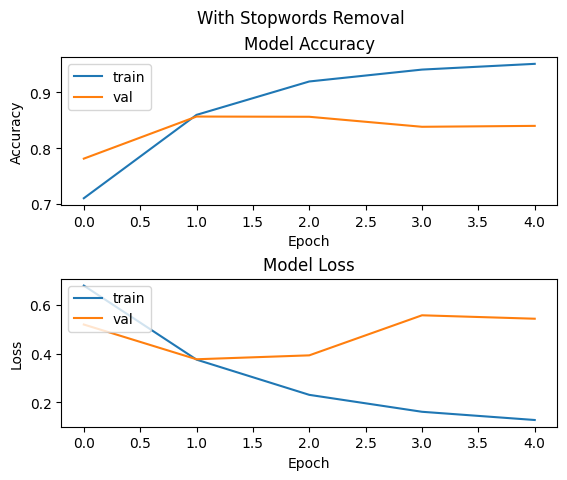

In [17]:
import matplotlib.pyplot as plt

# Get the training history
history = model.history

# Create a figure and axis
fig, axs = plt.subplots(2)
# Add a main title
fig.suptitle('With Stopwords Removal')

# Plot the accuracy
axs[0].plot(history.history['accuracy'])
axs[0].plot(history.history['val_accuracy'])
axs[0].set_title('Model Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend(['train', 'val'], loc='upper left')

# Plot the loss
axs[1].plot(history.history['loss'])
axs[1].plot(history.history['val_loss'])
axs[1].set_title('Model Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend(['train', 'val'], loc='upper left')

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0.5)

# Display the plot
plt.show()


In [18]:
# classification report

from sklearn.metrics import classification_report


class_report = classification_report(y_test_e100_8020.argmax(axis=1), model.predict(X_test_e100_8020).argmax(axis=1), target_names=['negative', 'neutral', 'positive'])
print(class_report) 

77/77 [==============================] - 5s 45ms/step
              precision    recall  f1-score   support

    negative       0.78      0.80      0.79       806
     neutral       0.82      0.61      0.70       251
    positive       0.88      0.91      0.89      1395

    accuracy                           0.84      2452
   macro avg       0.83      0.77      0.79      2452
weighted avg       0.84      0.84      0.84      2452

